In [1]:
import pandas as pd 
import shap
import numpy as np
import joblib
import time
import sklearn.metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## SHAP

In [4]:
test = pd.read_csv('./DS/test_original.csv')
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test).astype(np.float32)
y_test = pd.DataFrame(y_test)
labels = label_encoder.classes_

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping (Original -> Encoded):")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label} -> {encoded_label}")

Label Mapping (Original -> Encoded):
NORMAL -> 0
c_ci_na_1 -> 1
c_ci_na_1_DoS -> 2
c_rd_na_1 -> 3
c_rd_na_1_DoS -> 4
c_rp_na_1 -> 5
c_rp_na_1_DoS -> 6
c_sc_na_1 -> 7
c_sc_na_1_DoS -> 8
c_se_na_1 -> 9
c_se_na_1_DoS -> 10
m_sp_na_1_DoS -> 11


In [5]:
train = pd.read_csv('./DS/iec104_custom_script_train_final.csv')
test = pd.read_csv('./DS/iec104_custom_script_test_final.csv')
X_train = train.drop(['Label'], axis=1)
y_train = train['Label']
X_test = test.drop(['Label'], axis=1)
y_test = test['Label']
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train).astype(np.float32)
y_test = label_encoder.transform(y_test).astype(np.float32)
y_test = pd.Series(y_test)
y_train = pd.Series(y_train)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

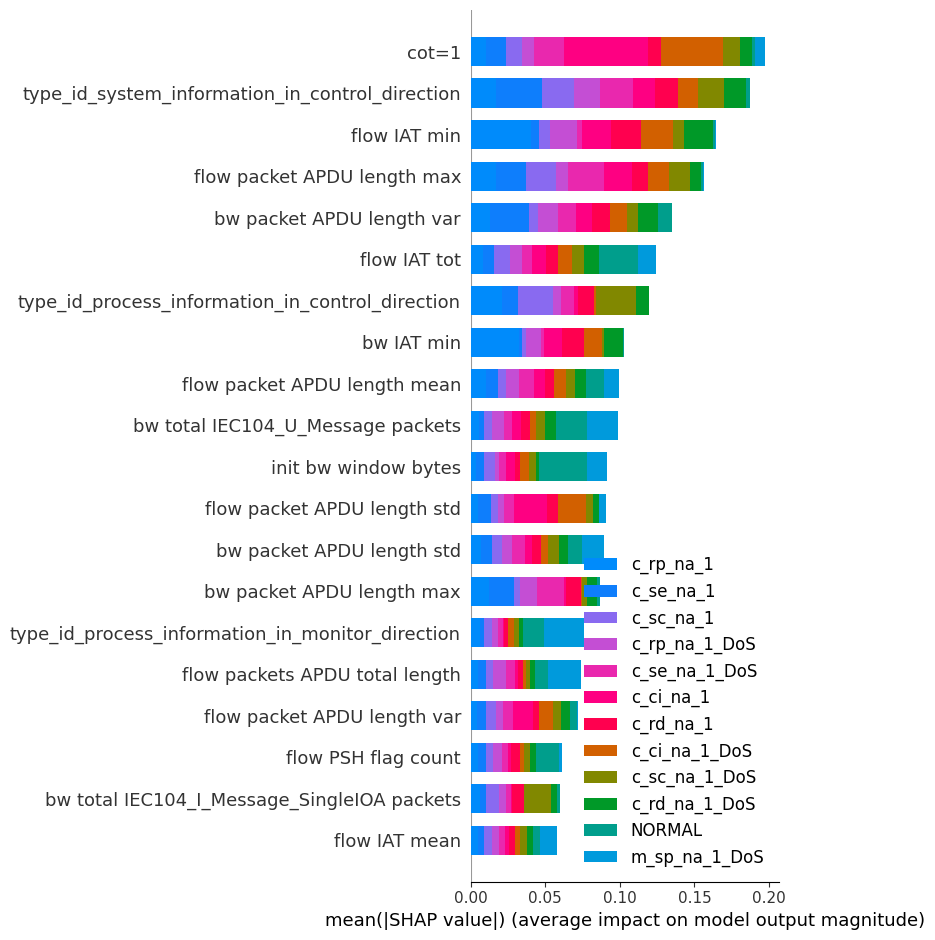

In [8]:
explainer = shap.Explainer(et_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=labels, show=False)

In [9]:
mean_abs_shap_values = np.mean(np.abs(shap_values), axis=(0, 1))

feature_ranking = pd.DataFrame({'Feature': X_test.columns, 'Mean Absolute SHAP Value': mean_abs_shap_values})

feature_ranking = feature_ranking.sort_values(by='Mean Absolute SHAP Value', ascending=False)

print(feature_ranking)

                                             Feature  Mean Absolute SHAP Value
91                                             cot=1                  0.016434
108  type_id_system_information_in_control_direction                  0.015606
13                                      flow IAT min                  0.013694
31                       flow packet APDU length max                  0.013015
45                         bw packet APDU length var                  0.011272
..                                               ...                       ...
54        flow total IEC104_I_Message_SeqIOA packets                  0.000000
42                         bw packet APDU length min                  0.000000
37                         fw packet APDU length min                  0.000000
32                       flow packet APDU length min                  0.000000
110                            type_id_file_transfer                  0.000000

[111 rows x 2 columns]


In [71]:
accuracies = []
f1_scores = []
precisions = []
recalls = []

for threshold in [0.005, 0.0025, 0.001, 0.00075, 0.0005, 0.0001, 0.000075 , 0.00005]:
    top_features = feature_ranking[feature_ranking['Mean Absolute SHAP Value'] > threshold]['Feature'].tolist()
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]
    
    et_params = {
        "n_estimators": 7,
        "max_leaf_nodes": 12000,
        "n_jobs": -1,
        "random_state": 0,
        "bootstrap": True,
        "criterion": "entropy"
    }

    et_model = ExtraTreesClassifier(**et_params)
    et_model.fit(X_train_selected, y_train)

    y_pred = et_model.predict(X_test_selected)

    acc = sklearn.metrics.accuracy_score(y_pred, y_test)
    precision = sklearn.metrics.precision_score(y_pred, y_test, average='micro')
    f1 = sklearn.metrics.f1_score(y_pred, y_test, average='macro')
    recall = sklearn.metrics.recall_score(y_pred, y_test, average='macro')
    cm = sklearn.metrics.confusion_matrix(y_pred, y_test)

    accuracies.append(acc)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

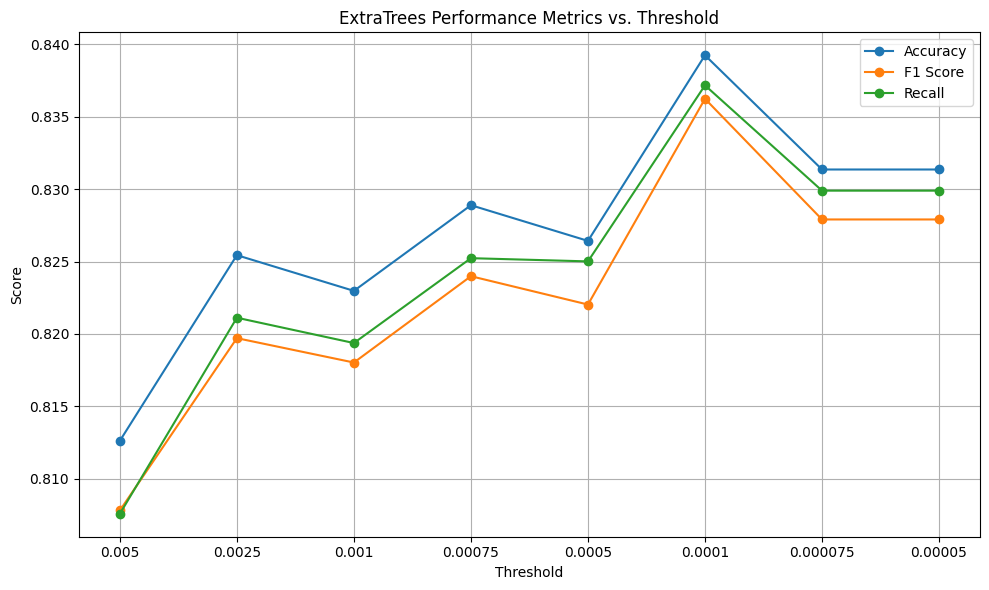

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(['0.005', '0.0025', '0.001', '0.00075', '0.0005', '0.0001', '0.000075', '0.00005'], accuracies, label='Accuracy', marker='o')
plt.plot(['0.005', '0.0025', '0.001', '0.00075', '0.0005', '0.0001', '0.000075', '0.00005'], f1_scores, label='F1 Score', marker='o')
plt.plot(['0.005', '0.0025', '0.001', '0.00075', '0.0005', '0.0001', '0.000075', '0.00005'], recalls, label='Recall', marker='o')
# plt.plot(['0.005', '0.0025', '0.001', '0.00075', '0.0005', '0.0001', '0.000075', '0.00005'], precisions, label='Precision', marker='o')

plt.title('ExtraTrees Performance Metrics vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.xticks(['0.005', '0.0025', '0.001', '0.00075', '0.0005', '0.0001', '0.000075', '0.00005'])
plt.tight_layout()
plt.show()